# Predicting Car Prices
---
We'll practice the machine learning workflow you've learned so far to predict a car's market price using its attributes. The data set we will be working with contains information on various cars. For each car we have information about the technical aspects of the vehicle such as the motor's displacement, the weight of the car, the miles per gallon, how fast the car accelerates, and more. You can read more about the data set [here](https://archive.ics.uci.edu/ml/datasets/automobile) and can download it directly from [here](https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data).

### Prereqs

In [1]:
#Importing libraries
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

pd.options.display.max_columns = 99

In [2]:
#Setting column names
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars=pd.read_csv('imports-85.data',names=cols)

#Printing the first three rows
cars.head(3)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500


In [3]:
#Checking the data type
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
symboling            205 non-null int64
normalized-losses    205 non-null object
make                 205 non-null object
fuel-type            205 non-null object
aspiration           205 non-null object
num-of-doors         205 non-null object
body-style           205 non-null object
drive-wheels         205 non-null object
engine-location      205 non-null object
wheel-base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb-weight          205 non-null int64
engine-type          205 non-null object
num-of-cylinders     205 non-null object
engine-size          205 non-null int64
fuel-system          205 non-null object
bore                 205 non-null object
stroke               205 non-null object
compression-rate     205 non-null float64
horsepower           205 non-nul

Since our machine learning will only take numbers, we should drop columns which includes types other than numbers (integers or floats). We will use the documentation to decide which columns to drop.

In [4]:
#Selecting numerical values
continuous_values_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars = cars[continuous_values_cols]

#Checking the changes
cars.head(5)

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,?,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495
1,?,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500
2,?,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500
3,164,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950
4,164,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450


### Data Cleaning
The `normalized-losses` column seems a little bit off, the documentation said that it is supposed to be continuous but it seems to be a `?` in it.

In [5]:
#Checking normalized-losses column
cars['normalized-losses'].value_counts(dropna=False)

?      41
161    11
91      8
150     7
134     6
128     6
104     6
95      5
94      5
74      5
103     5
85      5
102     5
168     5
65      5
122     4
148     4
93      4
118     4
106     4
115     3
125     3
101     3
137     3
83      3
154     3
110     2
145     2
87      2
164     2
194     2
158     2
113     2
153     2
188     2
108     2
119     2
89      2
197     2
129     2
81      2
192     2
231     1
121     1
256     1
186     1
78      1
77      1
107     1
90      1
98      1
142     1
Name: normalized-losses, dtype: int64

We are going to change the value of ? for all columns if it exists into np.nan and fill the nan with the average value.

In [6]:
#Changing the values
cars = cars.replace('?', np.nan)

#Checking the change
cars.head(3)

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,NaN,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495
1,NaN,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500
2,NaN,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500


In [7]:
cars = cars.astype('float')
cars.isnull().sum()

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

It seemed like there are also other columns with null values other than `normalized-losses`. We are going to fill that with the average value as mentioned previously. We will also be dropping missing values.

In [8]:
# Because `price` is the column we want to predict, let's remove any rows with missing `price` values.
cars.dropna(subset=['price'],inplace=True)
cars.fillna(cars.mean(),inplace=True)
cars.isnull().sum()

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-size          0
bore                 0
stroke               0
compression-rate     0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

In [9]:
# Normalize all columnns to range from 0 to 1 except the target column.
price_col = cars['price']
cars = (cars - cars.min())/(cars.max() - cars.min())
cars['price'] = price_col

#Checking the changes
cars.head(3)

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.125,0.294393,0.346939,0.222222,0.289474,13495.0
1,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.125,0.294393,0.346939,0.222222,0.289474,16500.0
2,0.298429,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,0.666667,0.125,0.495327,0.346939,0.166667,0.263158,16500.0


### Univariate K-Nearest Neighbor

In [10]:
def knn_train_test(train_col, target_col, df):
    knn = KNeighborsRegressor()
    np.random.seed(1)
        
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[:round(len(rand_df)*0.5)]
    test_df = rand_df.iloc[round(len(rand_df)*0.5):]
    
    # Fit a KNN model using default k value.
    knn.fit(train_df[[train_col]], train_df[target_col])
    
    # Make predictions using model.
    predicted_labels = knn.predict(test_df[[train_col]])

    # Calculate and return RMSE.
    mse = mean_squared_error(test_df[target_col], predicted_labels)
    rmse = np.sqrt(mse)
    return rmse
rmse_results = {}

#Testing Univariate with default k to all columns
train_cols = cars.columns.drop('price')

for col in train_cols:
    rmse_val = knn_train_test(col, 'price', cars)
    rmse_results[col] = rmse_val

# Create a Series object from the dictionary so 
# we can easily view the results, sort, etc
rmse_results_series = pd.Series(rmse_results)
rmse_results_series.sort_values()

engine-size          3238.462830
horsepower           4037.037713
curb-weight          4401.118255
highway-mpg          4630.026799
width                4704.482590
city-mpg             4766.422505
length               5427.200961
wheel-base           5461.553998
compression-rate     6610.812153
bore                 6780.627785
normalized-losses    7330.197653
peak-rpm             7697.459696
stroke               8006.529545
height               8144.441043
dtype: float64

With the default k, we can see that the best univariate model to predict the price of the car goes to engine-size. But what if we can decide the value of k ourselves?

In [11]:
def knn_train_test(train_col, target_col, df):
    np.random.seed(1)
        
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[:round(len(rand_df)*0.5)]
    test_df = rand_df.iloc[round(len(rand_df)*0.5):]
    
    k_values = [1,3,5,7,9]
    k_rmses = {}
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[[train_col]], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[[train_col]])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

#Testing Univariate with default k to all columns
train_cols = cars.columns.drop('price')

for col in train_cols:
    rmse_val = knn_train_test(col, 'price', cars)
    k_rmse_results[col] = rmse_val

k_rmse_results

{'bore': {1: 8602.58848450066,
  3: 6984.239489480916,
  5: 6780.627784685976,
  7: 6878.097965921532,
  9: 6866.808502038413},
 'city-mpg': {1: 5901.143574354764,
  3: 4646.746408727155,
  5: 4766.422505090134,
  7: 5232.523034167316,
  9: 5465.209492527533},
 'compression-rate': {1: 8087.205346523092,
  3: 7375.063685578359,
  5: 6610.812153159129,
  7: 6732.801282941515,
  9: 7024.485525463435},
 'curb-weight': {1: 5264.290230758878,
  3: 5022.318011757233,
  5: 4401.118254793124,
  7: 4330.608104418053,
  9: 4632.044474454401},
 'engine-size': {1: 3258.4861059962027,
  3: 2840.562805643501,
  5: 3238.4628296477176,
  7: 3563.086774256415,
  9: 3831.8244149840766},
 'height': {1: 8904.04645636071,
  3: 8277.609643045525,
  5: 8144.441042663747,
  7: 7679.598124393773,
  9: 7811.03606291223},
 'highway-mpg': {1: 6025.594966720739,
  3: 4617.305019788554,
  5: 4630.026798588056,
  7: 4796.061440186946,
  9: 5278.358056953987},
 'horsepower': {1: 4170.054848037801,
  3: 4020.8492630885

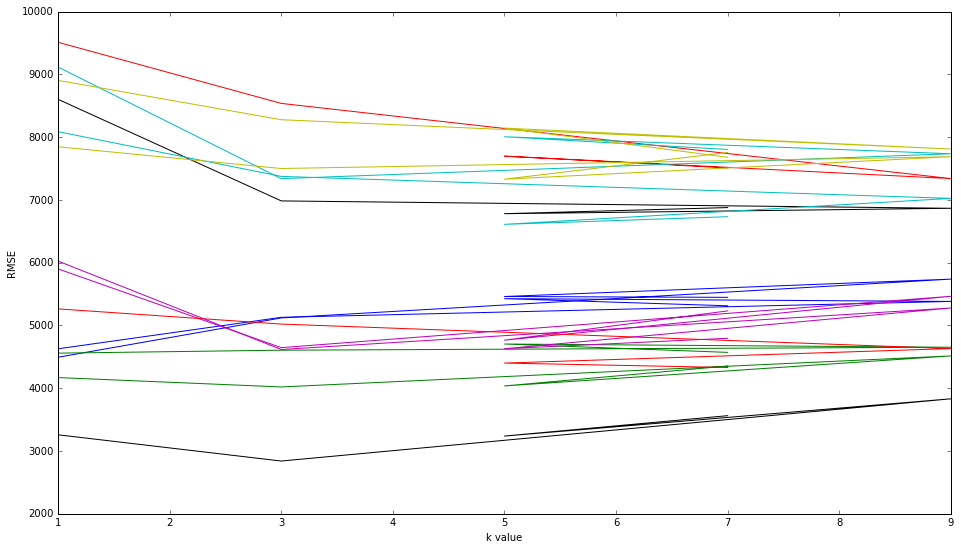

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,9))

for k,v in k_rmse_results.items():
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x,y)
    plt.xlabel('k value')
    plt.ylabel('RMSE')

As we can see, the best k value for different columns differ from each other. 

### Multivariate Model

In [13]:
# Compute average RMSE across different `k` values for each feature.
feature_avg_rmse = {}
for k,v in k_rmse_results.items():
    avg_rmse = np.mean(list(v.values()))
    feature_avg_rmse[k] = avg_rmse
series_avg_rmse = pd.Series(feature_avg_rmse)
sorted_series_avg_rmse = series_avg_rmse.sort_values()
print(sorted_series_avg_rmse)

sorted_features = sorted_series_avg_rmse.index

engine-size          3346.484586
horsepower           4219.377860
width                4618.910560
curb-weight          4730.075815
highway-mpg          5069.469256
length               5176.394904
city-mpg             5202.409003
wheel-base           5252.392462
compression-rate     7166.073599
bore                 7222.472445
normalized-losses    7624.407151
stroke               8000.240467
peak-rpm             8119.365233
height               8163.346266
dtype: float64


In [14]:
def knn_train_test(train_cols, target_col, df):
    np.random.seed(1)
    
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [5]
    k_rmses = {}
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[train_cols])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

for nr_best_feats in range(2,7):
    k_rmse_results['{} best features'.format(nr_best_feats)] = knn_train_test(
        sorted_features[:nr_best_feats],
        'price',
        cars
    )

k_rmse_results

{'2 best features': {5: 2949.8817277180374},
 '3 best features': {5: 3580.7376651928435},
 '4 best features': {5: 3487.340917327035},
 '5 best features': {5: 3410.2170133901805},
 '6 best features': {5: 3478.510890118539}}

After finding the mean value for each column, we selected the 2 best features until the 6 best features and loop it to find it RMSE values. With k=5, the best model is from the 2 best features.

### Hyperparameter Tuning

In [15]:
def knn_train_test(train_cols, target_col, df):
    np.random.seed(1)
    
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[:round(len(rand_df)*0.5)]
    test_df = rand_df.iloc[round(len(rand_df)*0.5):]
    
    k_values = [i for i in range(1, 25)]
    k_rmses = {}
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[train_cols])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

for nr_best_feats in range(2,6):
    k_rmse_results['{} best features'.format(nr_best_feats)] = knn_train_test(
        sorted_features[:nr_best_feats],
        'price',
        cars
    )

k_rmse_results

{'2 best features': {1: 2783.6204237227344,
  2: 2657.7963807419765,
  3: 2792.586573031673,
  4: 2891.5329686923255,
  5: 2949.8817277180374,
  6: 3096.402601694776,
  7: 3164.681969020496,
  8: 3413.228359192009,
  9: 3748.6716603306486,
  10: 4080.7125057341937,
  11: 4215.6372280600335,
  12: 4275.421524277872,
  13: 4373.901683035496,
  14: 4424.285137239815,
  15: 4539.505493095937,
  16: 4667.307671446768,
  17: 4729.605305844226,
  18: 4790.556632159094,
  19: 4824.3866193292615,
  20: 4840.850914693829,
  21: 4837.429062000271,
  22: 4831.16988267597,
  23: 4861.679492959275,
  24: 4903.346008862579},
 '3 best features': {1: 3399.8148100410203,
  2: 3497.191103423058,
  3: 3333.6966577570593,
  4: 3355.8842294742026,
  5: 3580.7376651928435,
  6: 3732.943016673517,
  7: 3639.9439408462786,
  8: 3747.4209132113137,
  9: 3986.593913133887,
  10: 4005.354888715163,
  11: 4121.687230061635,
  12: 4255.700651624227,
  13: 4328.476829895253,
  14: 4332.216494947217,
  15: 4388.22571

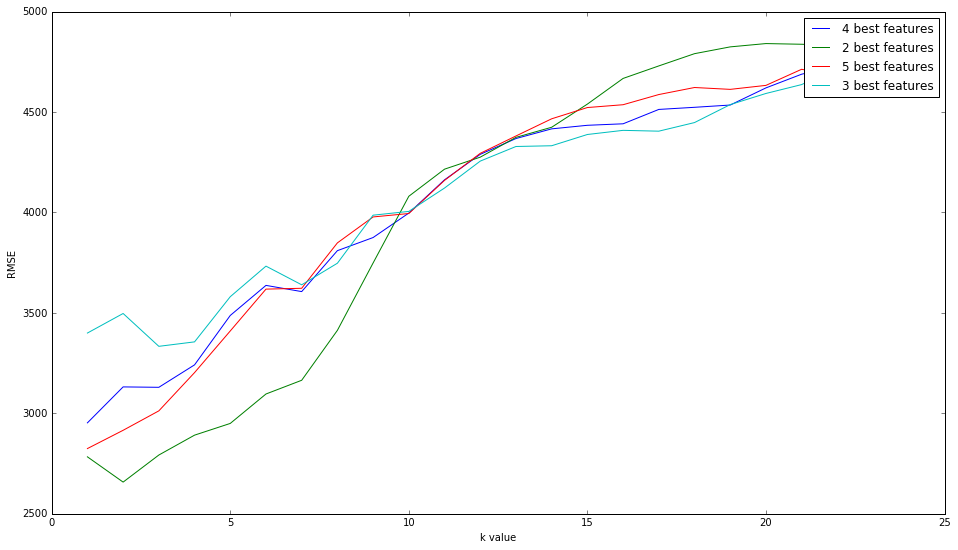

In [16]:
plt.figure(figsize=(16,9))
for k,v in k_rmse_results.items():
    x = list(v.keys())
    y = list(v.values())  
    plt.plot(x,y, label="{}".format(k))
    
plt.xlabel('k value')
plt.ylabel('RMSE')
plt.legend()

After looking at the hyperparameter tuning values, different models require different k value in order to make it more accurate.